<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/deeperfont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install dependencies for colab.research.google.com.
#!pip install -I tensorflow==1.11.0
#!pip install tensorflow-probability-gpu
#!pip install dm-sonnet
#!pip install tfp-nightly

# Install dependencies for GCP Deep Learning VM.
! pip3 install tensorflow-gpu
! pip3 install dm-sonnet
! pip3 install tensorflow-probability-gpu
! pip3 install wrapt

  Using cached https://files.pythonhosted.org/packages/75/8a/82b21bfc7115b8463d3d697aa9add3747c85f447b0b6f903a856b9e78c3f/tensorflow_probability_gpu-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a0/47/66897906448185fcb77fc3c2b1bc20ed0ecca81a0f2f88eda3fc5a34fc3d/wrapt-1.10.11.tar.gz
  Running setup.py bdist_wheel for wrapt ... done
  Stored in directory: /home/jupyter/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built wrapt


In [4]:
from enum import Enum, IntEnum
import math
import os
import time
import numpy as np
print(np.__version__)
import tensorflow as tf
print(tf.__version__)
import sonnet as snt
print(snt.__version__)
np.set_printoptions(precision=2)
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display

# hosted colab versions
# np 1.14.6
# tf 1.11.0
# snt 1.23

1.15.1
1.11.0


/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


1.26


In [5]:
class Stroke(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    DX = 0
    DY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum

In [6]:
def drawOutlines(outlines, cellsize, glyphCount):
  """Draw outlines from array."""
  im = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0))
  def drawPoints(im, points):
    if len(points)<=2:
      return im
    #temporary image to use to xor each part with main image
    im2 = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im2).polygon(points, fill=1)
    return ImageChops.logical_xor(im, im2)
  scale = cellsize * 0.9
  for font in range(outlines.shape[0]):
    i = 0
    for glyphNum in range(glyphCount):
      points = []
      x,y = (glyphNum * cellsize, (font+1) * cellsize)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, glyphNum * cellsize, (font+1) * cellsize), fill=1)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, (glyphNum+1) * cellsize, font * cellsize), fill=1)
      while True:
        x += outlines[font,i,Stroke.DX]*scale
        y -= outlines[font,i,Stroke.DY]*scale
        #print(outlines[font,i], x,y)
        if outlines[font,i,Stroke.PenDown]>0.5:
          points += (x,y)
        else:
          im = drawPoints(im, points)
          points=[(x,y)]
        i+=1
        if outlines[font,i-1,Stroke.EndOfGlyph]>0.5 or i>=outlines.shape[1]:
          break
      im = drawPoints(im, points)
      if i>=outlines.shape[1]:
        break
  return im

In [7]:
def outlinesToScanlines(outlines, max_points_per_scanline, ygrid, glyphCount):
    '''
    Pure tensorflow function
    Input: 2D tensor of max_outline_points * Stroke (DX,DY,PenDown,EndOfGlyph)
    Output: glyphCount * y coord * sorted x coords for each scanline
    '''
    glyphNums = tf.cast(outlines[:-1,Stroke.EndOfGlyph]>0.5, tf.int32)
    glyphNums = tf.cumsum(glyphNums, axis=-1)
    glyphNums = tf.concat((tf.zeros([1], dtype=tf.int32), glyphNums), axis=0)
    glyphNums2D = tf.expand_dims(tf.range(glyphCount),-1)
    glyphNums2D = tf.tile(glyphNums2D, [1,glyphNums.shape[0]])
    glyphNums2D = tf.math.equal(glyphNums2D, glyphNums)
    glyphNums2D = tf.cast(glyphNums2D, tf.float32)
    xs = tf.cumsum(outlines[:,Stroke.DX] * glyphNums2D, axis=1)+1e-2
    ys = tf.cumsum(outlines[:,Stroke.DY] * glyphNums2D, axis=1)+1e-2
    #offset to create line start x1,y1 to end x2,y2
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    x1s = tf.expand_dims(xs[:,:-1], -1)
    x2s = tf.expand_dims(xs[:,1:], -1)
    y1s = tf.expand_dims(ys[:,:-1], -1)
    y2s = tf.expand_dims(ys[:,1:], -1)
    #linear interpolate the x coords for all lines at all y coord
    xxs = x1s + (x2s-x1s)*(ygrid-y1s)/(y2s-y1s)
    #zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(y1s<ygrid, ygrid<=y2s), tf.logical_and(y2s<ygrid, ygrid<=y1s))
    in_range = tf.logical_and(in_range, y2s!=y1s)
    visible = outlines[1:,Stroke.PenDown]>0.5
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)), max_points_per_scanline).values
  
def drawScanLines(xxs, ygrid, cellsize):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    columns = int(math.ceil(1000/cellsize))
    rows = 1 #math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
      yy,xx = divmod(i, columns)
      xx *= cellsize
      yy = (yy+1)*cellsize-1
      for xs, y in zip(xxs[i], ygrid):
        for j in range(0, xs.shape[0], 2):
          if(xs[j]>1e-5):
            if(xs[j+1]>1e-5):
              draw.line((xx+xs[j]*scale, yy-y*scale, xx+xs[j+1]*scale, yy-y*scale), fill=1)
            else:
              draw.ellipse((xx+xs[j]*scale-1, yy-y*scale-1, xx+xs[j]*scale+1, yy-y*scale+1), fill=1)
    return im  

In [8]:
def parse_proto(example_proto):
  features = {
    'glyphNum': tf.FixedLenFeature([1], tf.int64),
    'max_outline_points': tf.FixedLenFeature([1], tf.int64),
    'outline': tf.FixedLenFeature([5000*4], tf.float32),
  }
  return tf.parse_single_example(example_proto, features)

#filename = '/content/gdrive/My Drive/Colab Notebooks/fonts8.tfrecords'
filename = '/home/jupyter/ipython_notebooks/deeper/fonts/fonts8.tfrecords'
dataset = tf.data.TFRecordDataset(filename).map(parse_proto)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)
/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


In [9]:
# Plot first row of original data
dataset_iter = dataset.make_one_shot_iterator()
batch = dataset_iter.get_next()

with tf.Session():
  glyphNum = int(batch["glyphNum"].eval()[0])
  max_outline_points = batch["max_outline_points"].eval()[0]
  outlines = tf.reshape(batch["outline"], (-1, max_outline_points, Stroke.Size)).eval()
  print(outlines.shape)
  assert glyphNum == 63
  assert max_outline_points == 5000
  assert outlines.shape[0] == 1

outlines = outlines[:,0:200,:]
print("outline shape (fonts, points_per_outline, Stroke.Size): ", outlines.shape)
display(drawOutlines(outlines, cellsize=30, glyphCount=glyphNum))

with tf.Session():
  y_divisions = 30
  max_points_per_scanline = 8
  ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False) #y coordinates to render on
  scanlines = outlinesToScanlines(outlines[0], max_points_per_scanline, ygrid, glyphNum)
  print("scanlines shape (glyphs, lines, max_points_per_line): ", scanlines.shape)
  display(drawScanLines(scanlines.eval(), ygrid, 30))
  

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


(1, 5000, 4)
outline shape (fonts, points_per_outline, Stroke.Size):  (1, 200, 4)


scanlines shape (glyphs, lines, max_points_per_line):  (63, 30, 8)


In [10]:
def encoder(x, latent_dim, hidden_size):
  """Construct an inference network parametrizing a Gaussian.
  Args:
    x: Outlines.
    latent_dim: The latent dimensionality.
    hidden_size: The size of the neural net hidden layers.
  Returns:
    mu: Mean parameters for the variational family Normal
    sigma: Standard deviation parameters for the variational family Normal
  """
  with tf.name_scope("encoder"):
    flat = snt.BatchFlatten()(x)
    hidden1 = tf.nn.elu(snt.Linear(hidden_size)(flat))
    hidden2 = tf.nn.elu(snt.Linear(hidden_size)(hidden1))
    # The mean and log variance are unconstrained
    latent_mean = snt.Linear(latent_dim)(hidden2)  
    latent_log_var = snt.Linear(latent_dim)(hidden2)
    return latent_mean, latent_log_var


def decoder(z, hidden_size):
  """Build a generative network parametrizing the likelihood of the data
  Args:
    z: Samples of latent variables
    hidden_size: Size of the hidden state of the neural net
  Returns:
    gaussian_logits for the 2x real variables
    bernoulli_logits for the likelihood of the 2x bool data
  """
  with tf.name_scope("decoder"):
    hidden1 = tf.nn.elu(snt.Linear(hidden_size)(z))
    hidden2 = tf.nn.elu(snt.Linear(hidden_size)(hidden1))
    output = snt.Linear(np.prod(posterior_sample_shape))(hidden2)
    logits = snt.BatchReshape(posterior_sample_shape)(output) # Q: are these really logits?
    p_x_given_z1 = tf.distributions.Normal(loc=logits[...,0:2], 
                                           scale=tf.sqrt(tf.clip_by_value(tf.exp(logits[...,2:4]), 1e-2, 2.0)),
                                           validate_args=True, allow_nan_stats=False)
    p_x_given_z2 = tf.distributions.Bernoulli(logits=logits[...,4:6],
                                              validate_args=True, allow_nan_stats=False)
    return tf.concat([p_x_given_z1.sample(), tf.to_float(p_x_given_z2.sample())], axis=-1), logits, p_x_given_z1, p_x_given_z2


# https://github.com/altosaar/variational-autoencoder/blob/master/vae.py

def train_graph(x):
  with tf.name_scope('variational'):
    latent_mean, latent_log_var = encoder(x=x,
                                          latent_dim=FLAGS.latent_dim,
                                          hidden_size=FLAGS.hidden_size)
    latent_stdev = tf.sqrt(tf.exp(latent_log_var))
    q_z = tf.distributions.Normal(loc=latent_mean, scale=latent_stdev)
    assert q_z.reparameterization_type == tf.distributions.FULLY_REPARAMETERIZED

  with tf.name_scope('model'):
    # The likelihood is Bernoulli-distributed with logits given by the
    # generative decoder network
    posterior_predictive_samples, decoder_logits, p_x_given_z1, p_x_given_z2 = decoder(z=q_z.sample(), hidden_size=FLAGS.hidden_size)
    #tf.summary.image('posterior_predictive', posterior_predictive_samples)

    # Take samples from the prior
    p_z = tf.distributions.Normal(loc=np.zeros(FLAGS.latent_dim, dtype=np.float32),
                                  scale=np.ones(FLAGS.latent_dim, dtype=np.float32))
    prior_predictive_samples, _, _, _ = decoder(z=p_z.sample(FLAGS.n_samples), hidden_size=FLAGS.hidden_size)
    #tf.summary.image('prior_predictive', tf.cast(prior_predictive_samples, tf.float32))

    # Take samples from the prior with a placeholder
    #z_input = tf.placeholder(tf.float32, [None, FLAGS.latent_dim])
    #p_x_given_z_logits = decoder(z=z_input, hidden_size=FLAGS.hidden_size)
    #prior_predictive_inp = tf.distributions.Bernoulli(logits=p_x_given_z_logits)
    #prior_predictive_inp_sample = prior_predictive_inp.sample()

    # Build the evidence lower bound (ELBO) or the negative loss
    kl = tf.reduce_sum(tf.distributions.kl_divergence(q_z, p_z), 1)
    expected_log_likelihood1 = tf.reduce_sum(p_x_given_z1.log_prob(x[...,:Stroke.PenDown]), [1, 2])
    expected_log_likelihood2 = tf.reduce_sum(p_x_given_z2.log_prob(x[...,Stroke.PenDown:]), [1, 2])
    #global debug1, debug2, debug3
    #debug1 = tf.reduce_max(p_x_given_z1.log_prob(x[...,:Stroke.PenDown]))
    #debug2 = tf.reduce_max(p_x_given_z2.log_prob(x[...,Stroke.PenDown:]))
    #debug3 = kl
    elbo = tf.reduce_sum(expected_log_likelihood1 + expected_log_likelihood2 - kl, 0)
    
    # try optimising raw encoder/decoder
    # compare posterior 0:2 (mean) with DX/DY, and 4:6 (bernoulli p) with bool PenDown/EndOfGlyph
    #raw_loss = tf.reduce_sum(kl) + tf.losses.mean_squared_error(x[...,0:2], decoder_logits[...,0:2]) + \
    #  tf.losses.mean_squared_error(x[...,2:4], decoder_logits[...,4:6])
    raw_loss = tf.reduce_sum(kl) + tf.losses.mean_squared_error(x, posterior_predictive_samples)
    
    # Q: do we have any regularisation of encoder/decoder weights?
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    #return optimizer.minimize(-elbo), -elbo, posterior_predictive_samples, prior_predictive_samples
    return optimizer.minimize(raw_loss), raw_loss, posterior_predictive_samples, prior_predictive_samples

class FLAGS(): 
  logdir = "/tmp/tflog"
  iterations = 100000
  hidden_size = 100
  latent_dim = 64
  n_samples = 5
  print_every = 100
  batch_size = 100

batch_input_shape = [FLAGS.batch_size, max_outline_points, Stroke.Size]
outline_points = 200
input_shape = [outline_points, Stroke.Size]
posterior_sample_shape = [outline_points, 6] # 2x(mean, stdev, bool)
buffer_size=100
batched_dataset = dataset.shuffle(buffer_size)
batched_dataset = batched_dataset.repeat()
batched_dataset = batched_dataset.batch(FLAGS.batch_size)
batch = batched_dataset.make_one_shot_iterator().get_next()
outlines = tf.reshape(batch['outline'], batch_input_shape)
print(outlines.shape)
outlines = outlines[:,0:outline_points,:]
print(outlines.shape)
train_op, loss, posterior_predictive_samples, prior_predictive_samples = train_graph(outlines)

# Merge all the summaries
summary_op = tf.summary.merge_all()
    

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


(100, 5000, 4)
(100, 200, 4)


Iteration: 0 loss: 1270395812.988 s/iter: 3.492e-02


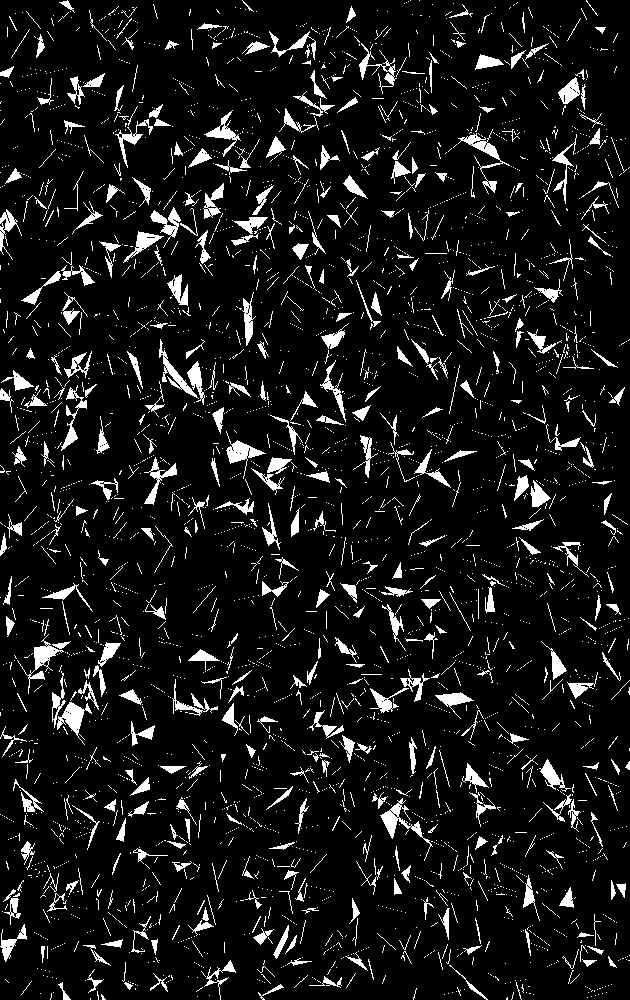

Iteration: 100 loss: 3273059.130 s/iter: 4.372e-02
Iteration: 200 loss: 2768180.370 s/iter: 2.188e-02
Iteration: 300 loss: 2695658.803 s/iter: 2.384e-02
Iteration: 400 loss: 2664524.913 s/iter: 2.402e-02
Iteration: 500 loss: 2654245.198 s/iter: 2.304e-02
Iteration: 600 loss: 2852411.270 s/iter: 2.148e-02
Iteration: 700 loss: 2690715.790 s/iter: 2.160e-02
Iteration: 800 loss: 2668605.149 s/iter: 2.249e-02
Iteration: 900 loss: 2633543.313 s/iter: 2.232e-02
Iteration: 1000 loss: 2629555.166 s/iter: 2.273e-02
Iteration: 1100 loss: 3130778.968 s/iter: 2.241e-02
Iteration: 1200 loss: 2964433.134 s/iter: 2.260e-02
Iteration: 1300 loss: 2840790.153 s/iter: 2.337e-02
Iteration: 1400 loss: 4137944.579 s/iter: 2.335e-02
Iteration: 1500 loss: 2964680.493 s/iter: 2.318e-02
Iteration: 1600 loss: 2614834.309 s/iter: 2.170e-02
Iteration: 1700 loss: 2667821.050 s/iter: 2.223e-02
Iteration: 1800 loss: 2894087.434 s/iter: 2.228e-02
Iteration: 1900 loss: 3726017.475 s/iter: 2.231e-02
Iteration: 2000 loss:

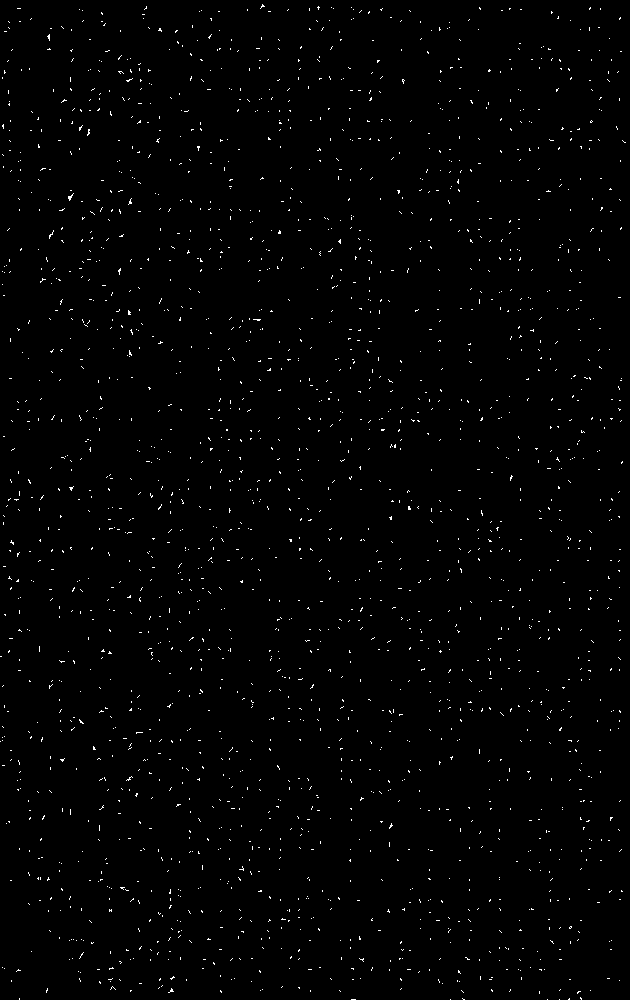

Iteration: 5100 loss: 3305961.788 s/iter: 4.284e-02
Iteration: 5200 loss: 3252930.939 s/iter: 2.218e-02
Iteration: 5300 loss: 2937832.773 s/iter: 2.354e-02
Iteration: 5400 loss: 3244028.091 s/iter: 2.270e-02
Iteration: 5500 loss: 3039803.505 s/iter: 2.316e-02
Iteration: 5600 loss: 2758991.122 s/iter: 2.280e-02
Iteration: 5700 loss: 2740926.445 s/iter: 2.249e-02
Iteration: 5800 loss: 3182840.049 s/iter: 2.271e-02
Iteration: 5900 loss: 3020432.889 s/iter: 2.229e-02
Iteration: 6000 loss: 2707017.660 s/iter: 2.299e-02
Iteration: 6100 loss: 2904385.030 s/iter: 2.266e-02
Iteration: 6200 loss: 2642406.225 s/iter: 2.323e-02
Iteration: 6300 loss: 3100351.393 s/iter: 2.294e-02
Iteration: 6400 loss: 2803638.279 s/iter: 2.213e-02
Iteration: 6500 loss: 3045173.287 s/iter: 2.295e-02
Iteration: 6600 loss: 2888490.260 s/iter: 2.296e-02
Iteration: 6700 loss: 2788452.804 s/iter: 2.285e-02
Iteration: 6800 loss: 2766690.254 s/iter: 2.273e-02
Iteration: 6900 loss: 2880625.129 s/iter: 2.254e-02
Iteration: 7

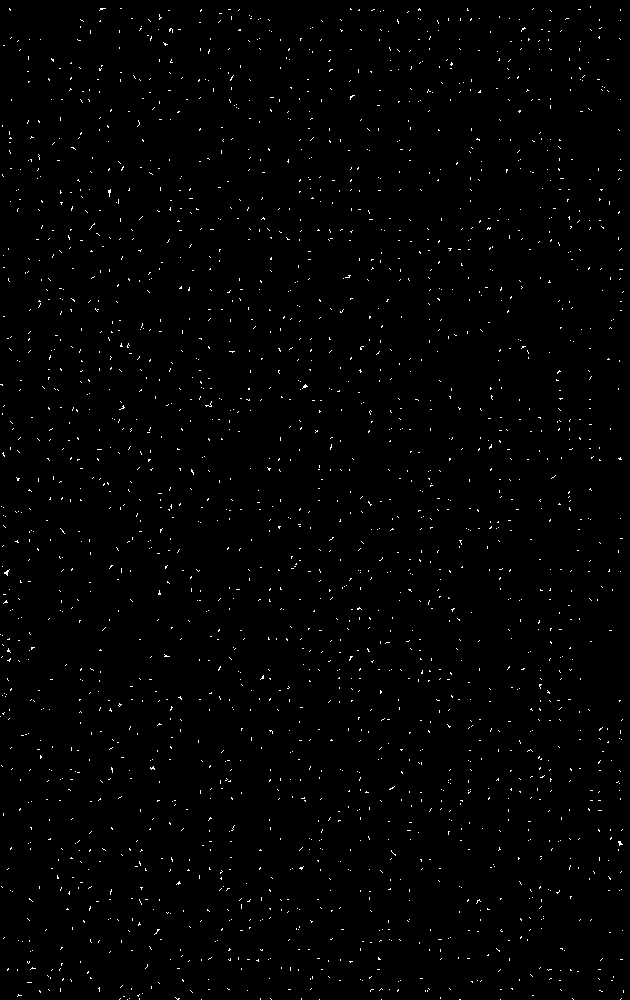

Iteration: 10100 loss: 2643544.078 s/iter: 4.306e-02
Iteration: 10200 loss: 2653113.008 s/iter: 2.242e-02
Iteration: 10300 loss: 2700203.359 s/iter: 2.229e-02
Iteration: 10400 loss: 2652643.919 s/iter: 2.236e-02
Iteration: 10500 loss: 2639801.204 s/iter: 2.232e-02
Iteration: 10600 loss: 2666096.985 s/iter: 2.220e-02
Iteration: 10700 loss: 2634280.622 s/iter: 2.221e-02
Iteration: 10800 loss: 2633804.381 s/iter: 2.317e-02
Iteration: 10900 loss: 2651053.667 s/iter: 2.270e-02
Iteration: 11000 loss: 2649032.772 s/iter: 2.266e-02
Iteration: 11100 loss: 2746564.746 s/iter: 2.197e-02
Iteration: 11200 loss: 2783119.678 s/iter: 2.247e-02
Iteration: 11300 loss: 2646805.644 s/iter: 2.276e-02
Iteration: 11400 loss: 2662954.628 s/iter: 2.315e-02
Iteration: 11500 loss: 2667216.659 s/iter: 2.230e-02
Iteration: 11600 loss: 2658102.810 s/iter: 2.282e-02
Iteration: 11700 loss: 2734393.477 s/iter: 2.353e-02
Iteration: 11800 loss: 2930408.418 s/iter: 2.256e-02
Iteration: 11900 loss: 2729929.686 s/iter: 2.3

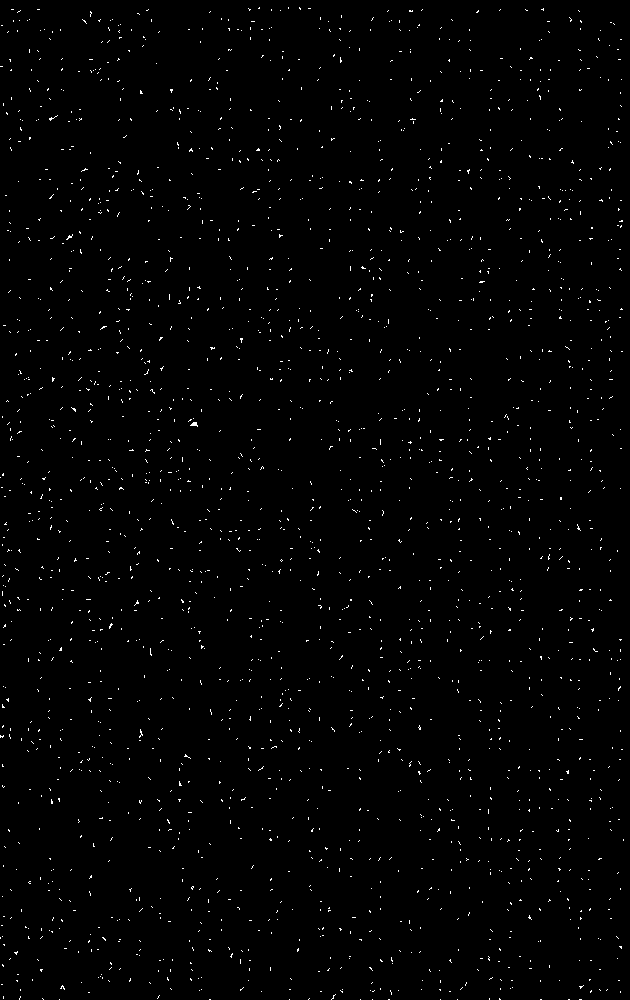

Iteration: 15100 loss: 2680624.723 s/iter: 4.460e-02
Iteration: 15200 loss: 2635630.667 s/iter: 2.275e-02
Iteration: 15300 loss: 3620452.583 s/iter: 2.277e-02
Iteration: 15400 loss: 2722503.841 s/iter: 2.333e-02
Iteration: 15500 loss: 2646601.796 s/iter: 2.297e-02
Iteration: 15600 loss: 2636603.713 s/iter: 2.277e-02
Iteration: 15700 loss: 2651373.148 s/iter: 2.265e-02
Iteration: 15800 loss: 3910552.263 s/iter: 2.241e-02
Iteration: 15900 loss: 2660351.098 s/iter: 2.290e-02
Iteration: 16000 loss: 2639108.002 s/iter: 2.227e-02
Iteration: 16100 loss: 2655405.104 s/iter: 2.269e-02
Iteration: 16200 loss: 2771230.936 s/iter: 2.265e-02
Iteration: 16300 loss: 2637092.769 s/iter: 2.247e-02
Iteration: 16400 loss: 2716785.371 s/iter: 2.262e-02
Iteration: 16500 loss: 2684785.724 s/iter: 2.279e-02
Iteration: 16600 loss: 2646414.042 s/iter: 2.297e-02
Iteration: 16700 loss: 2671715.617 s/iter: 2.299e-02
Iteration: 16800 loss: 2642785.013 s/iter: 2.276e-02
Iteration: 16900 loss: 2645434.439 s/iter: 2.2

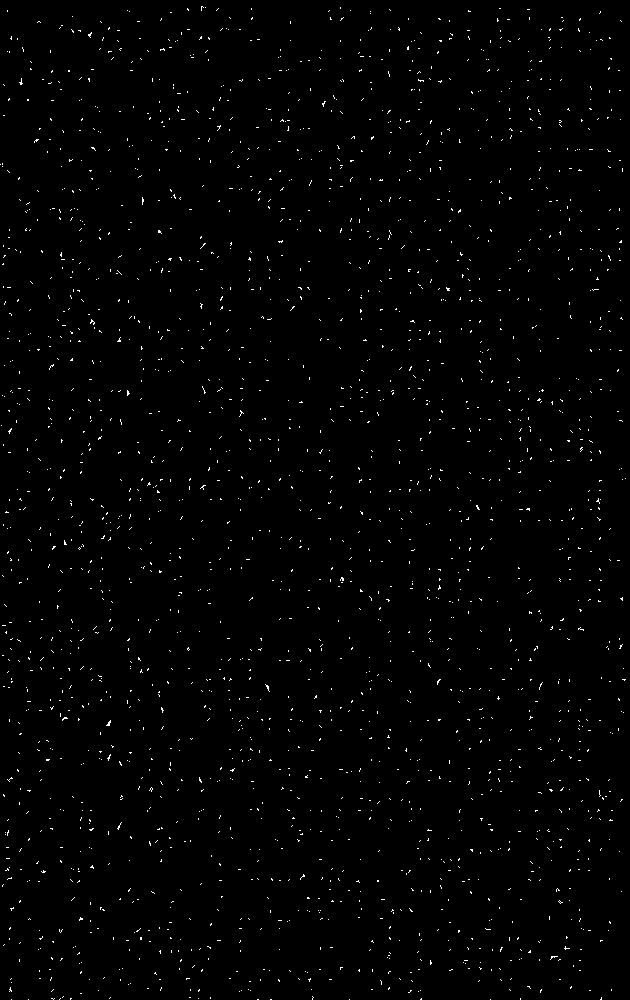

Iteration: 20100 loss: 2752755.582 s/iter: 4.555e-02
Iteration: 20200 loss: 2662140.131 s/iter: 2.291e-02
Iteration: 20300 loss: 2695681.155 s/iter: 2.343e-02
Iteration: 20400 loss: 2674778.700 s/iter: 2.199e-02
Iteration: 20500 loss: 2661500.871 s/iter: 2.146e-02
Iteration: 20600 loss: 2736086.249 s/iter: 2.304e-02
Iteration: 20700 loss: 2675509.751 s/iter: 2.259e-02
Iteration: 20800 loss: 2862419.486 s/iter: 2.203e-02
Iteration: 20900 loss: 2765167.952 s/iter: 2.314e-02
Iteration: 21000 loss: 2668302.655 s/iter: 2.302e-02
Iteration: 21100 loss: 2688247.263 s/iter: 2.280e-02
Iteration: 21200 loss: 2685095.370 s/iter: 2.271e-02
Iteration: 21300 loss: 2641052.306 s/iter: 2.337e-02
Iteration: 21400 loss: 2785463.929 s/iter: 2.255e-02
Iteration: 21500 loss: 2692877.650 s/iter: 2.179e-02
Iteration: 21600 loss: 2769491.076 s/iter: 2.288e-02
Iteration: 21700 loss: 2650221.884 s/iter: 2.174e-02
Iteration: 21800 loss: 2647657.990 s/iter: 2.324e-02
Iteration: 21900 loss: 2713549.137 s/iter: 2.2

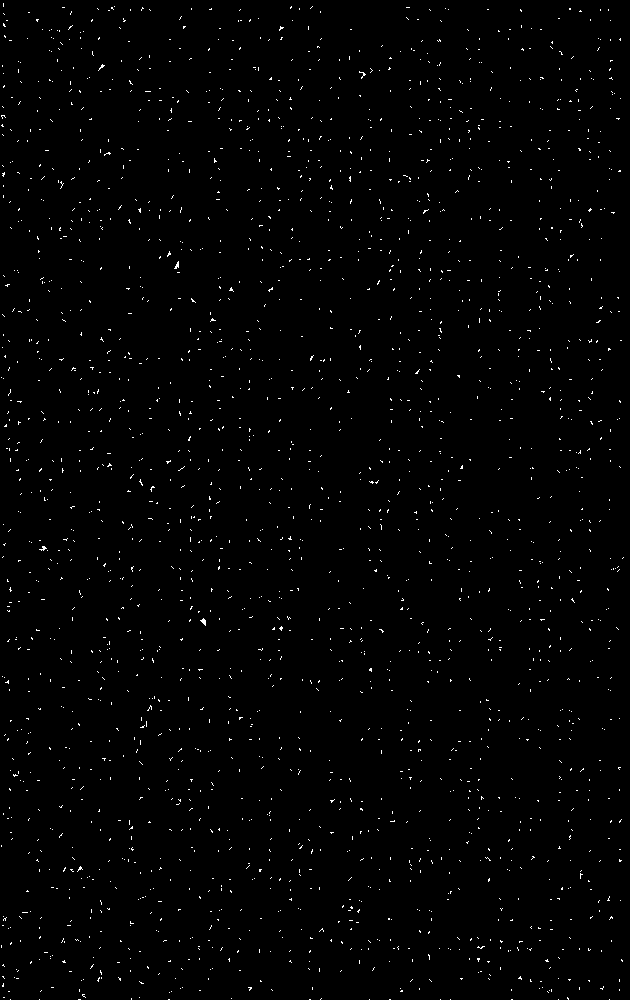

Iteration: 25100 loss: 2630481.124 s/iter: 4.476e-02
Iteration: 25200 loss: 2849412.858 s/iter: 2.229e-02
Iteration: 25300 loss: 2654914.558 s/iter: 2.245e-02
Iteration: 25400 loss: 2651925.981 s/iter: 2.274e-02
Iteration: 25500 loss: 2693845.332 s/iter: 2.274e-02
Iteration: 25600 loss: 2676144.242 s/iter: 2.251e-02
Iteration: 25700 loss: 2646956.146 s/iter: 2.154e-02
Iteration: 25800 loss: 2640212.774 s/iter: 2.228e-02
Iteration: 25900 loss: 2721340.358 s/iter: 2.114e-02
Iteration: 26000 loss: 2640420.496 s/iter: 2.198e-02
Iteration: 26100 loss: 2737638.354 s/iter: 2.297e-02
Iteration: 26200 loss: 2645047.605 s/iter: 2.284e-02
Iteration: 26300 loss: 2655923.963 s/iter: 2.280e-02
Iteration: 26400 loss: 2644601.166 s/iter: 2.233e-02
Iteration: 26500 loss: 2618953.884 s/iter: 2.331e-02
Iteration: 26600 loss: 2791369.557 s/iter: 2.256e-02
Iteration: 26700 loss: 2713540.494 s/iter: 2.324e-02
Iteration: 26800 loss: 2745471.597 s/iter: 2.396e-02
Iteration: 26900 loss: 2654411.495 s/iter: 2.2

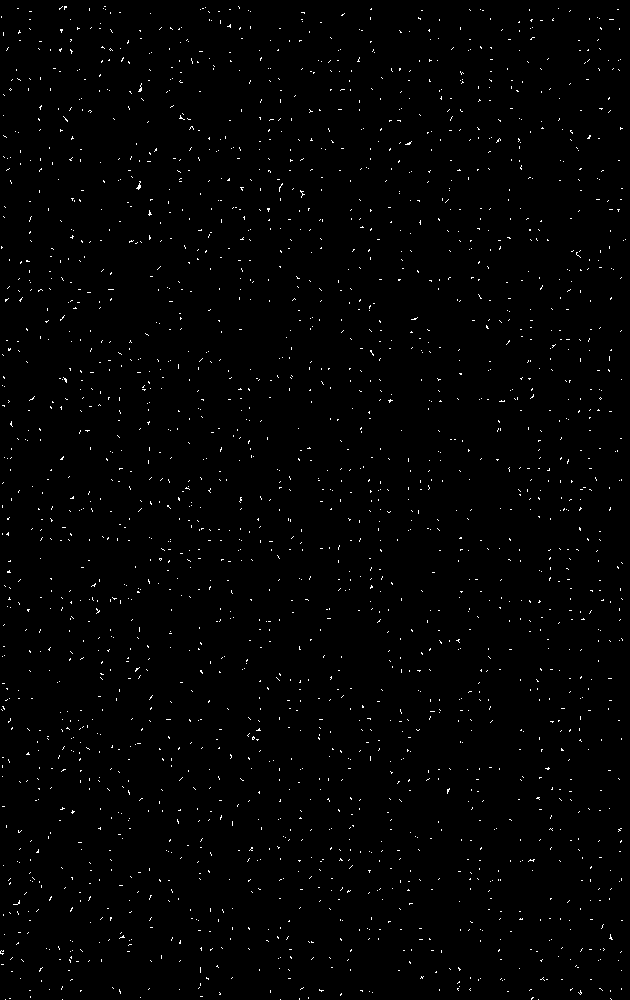

Iteration: 30100 loss: 2662253.976 s/iter: 4.461e-02
Iteration: 30200 loss: 2654905.617 s/iter: 2.178e-02
Iteration: 30300 loss: 2624963.224 s/iter: 2.292e-02
Iteration: 30400 loss: 2655777.335 s/iter: 2.270e-02
Iteration: 30500 loss: 2651220.858 s/iter: 2.218e-02
Iteration: 30600 loss: 2671782.970 s/iter: 2.250e-02
Iteration: 30700 loss: 2655920.088 s/iter: 2.247e-02
Iteration: 30800 loss: 2619688.213 s/iter: 2.234e-02
Iteration: 30900 loss: 2626277.208 s/iter: 2.209e-02
Iteration: 31000 loss: 2642957.568 s/iter: 2.260e-02
Iteration: 31100 loss: 2654480.636 s/iter: 2.248e-02
Iteration: 31200 loss: 2650015.950 s/iter: 2.260e-02
Iteration: 31300 loss: 2664580.643 s/iter: 2.546e-02
Iteration: 31400 loss: 2647901.773 s/iter: 2.550e-02
Iteration: 31500 loss: 14759473.801 s/iter: 2.506e-02
Iteration: 31600 loss: 2615023.553 s/iter: 2.455e-02
Iteration: 31700 loss: 2632083.595 s/iter: 2.166e-02
Iteration: 31800 loss: 2615971.863 s/iter: 2.241e-02
Iteration: 31900 loss: 2659824.491 s/iter: 2.

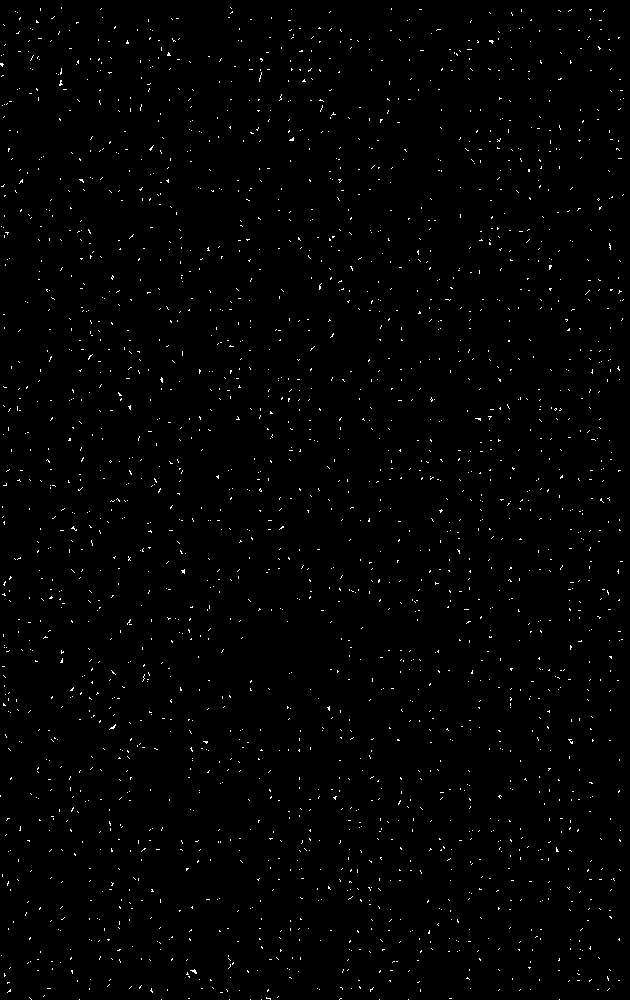

Iteration: 35100 loss: 2637618.184 s/iter: 4.485e-02
Iteration: 35200 loss: 2649381.459 s/iter: 2.281e-02
Iteration: 35300 loss: 2667942.047 s/iter: 2.305e-02
Iteration: 35400 loss: 2625859.380 s/iter: 2.306e-02
Iteration: 35500 loss: 2626953.721 s/iter: 2.259e-02
Iteration: 35600 loss: 2625654.936 s/iter: 2.245e-02
Iteration: 35700 loss: 2671507.597 s/iter: 2.272e-02
Iteration: 35800 loss: 2657693.326 s/iter: 2.297e-02
Iteration: 35900 loss: 2655872.107 s/iter: 2.322e-02
Iteration: 36000 loss: 2711894.214 s/iter: 2.209e-02
Iteration: 36100 loss: 2630359.232 s/iter: 2.291e-02
Iteration: 36200 loss: 2632071.376 s/iter: 2.321e-02
Iteration: 36300 loss: 2663931.847 s/iter: 2.263e-02
Iteration: 36400 loss: 2655951.381 s/iter: 2.225e-02
Iteration: 36500 loss: 2669282.556 s/iter: 2.185e-02
Iteration: 36600 loss: 2632349.133 s/iter: 2.243e-02
Iteration: 36700 loss: 2617790.103 s/iter: 2.307e-02
Iteration: 36800 loss: 2663255.632 s/iter: 2.222e-02
Iteration: 36900 loss: 2644158.006 s/iter: 2.2

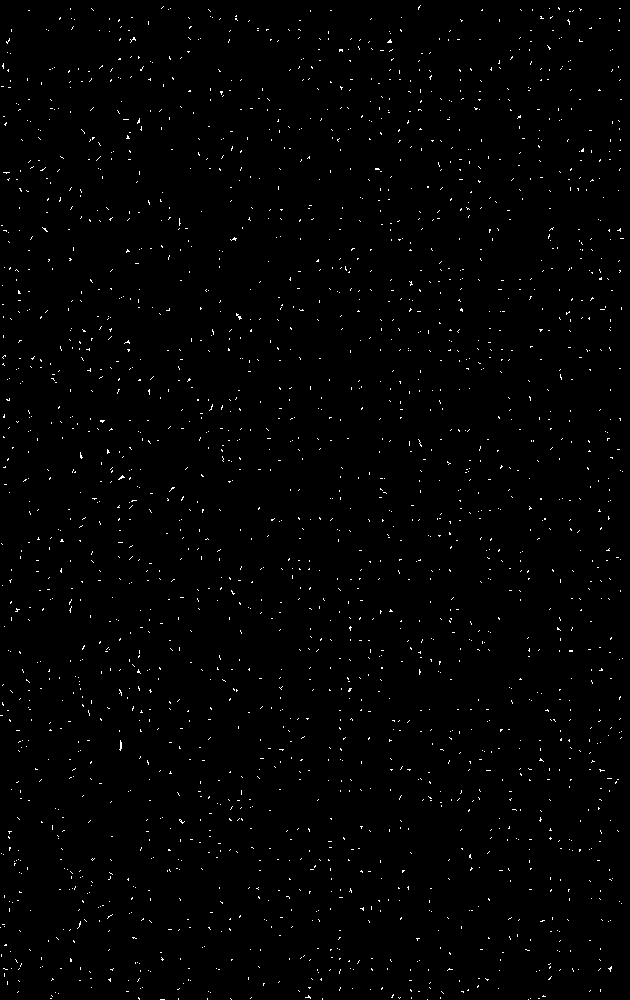

Iteration: 40100 loss: 2631493.509 s/iter: 4.441e-02
Iteration: 40200 loss: 2649571.598 s/iter: 2.223e-02
Iteration: 40300 loss: 2672060.430 s/iter: 2.111e-02
Iteration: 40400 loss: 2614227.235 s/iter: 2.193e-02
Iteration: 40500 loss: 2619708.180 s/iter: 2.173e-02
Iteration: 40600 loss: 2636738.122 s/iter: 2.294e-02
Iteration: 40700 loss: 2639238.834 s/iter: 2.334e-02
Iteration: 40800 loss: 92478466.034 s/iter: 2.288e-02
Iteration: 40900 loss: 2615041.435 s/iter: 2.284e-02
Iteration: 41000 loss: 2637080.550 s/iter: 2.271e-02
Iteration: 41100 loss: 2644930.780 s/iter: 2.267e-02
Iteration: 41200 loss: 2660490.572 s/iter: 2.304e-02
Iteration: 41300 loss: 2627736.926 s/iter: 2.288e-02
Iteration: 41400 loss: 2642097.175 s/iter: 2.260e-02
Iteration: 41500 loss: 2633212.805 s/iter: 2.273e-02
Iteration: 41600 loss: 2625172.436 s/iter: 2.284e-02
Iteration: 41700 loss: 2635502.219 s/iter: 2.250e-02
Iteration: 41800 loss: 2610920.966 s/iter: 2.287e-02
Iteration: 41900 loss: 2632597.685 s/iter: 2.

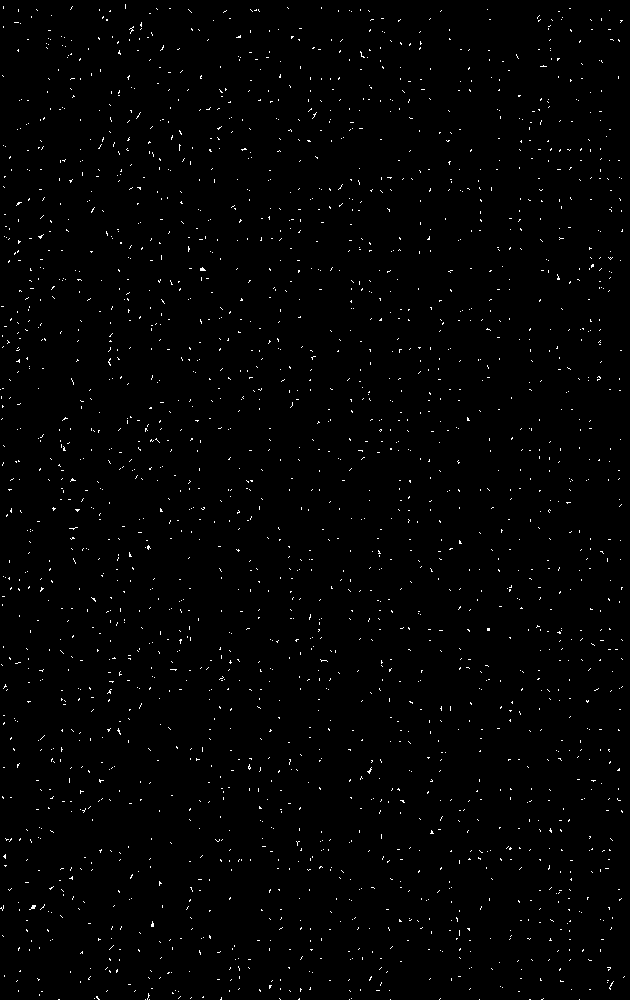

Iteration: 45100 loss: 2622190.118 s/iter: 4.525e-02
Iteration: 45200 loss: 2659075.558 s/iter: 2.263e-02
Iteration: 45300 loss: 2642369.866 s/iter: 2.279e-02
Iteration: 45400 loss: 2617181.242 s/iter: 2.263e-02
Iteration: 45500 loss: 2657891.512 s/iter: 2.276e-02
Iteration: 45600 loss: 2646536.827 s/iter: 2.248e-02
Iteration: 45700 loss: 2628376.782 s/iter: 2.328e-02
Iteration: 45800 loss: 2716513.574 s/iter: 2.227e-02
Iteration: 45900 loss: 2667678.297 s/iter: 2.237e-02
Iteration: 46000 loss: 2614162.862 s/iter: 2.247e-02
Iteration: 46100 loss: 2627321.780 s/iter: 2.251e-02
Iteration: 46200 loss: 2637672.126 s/iter: 2.311e-02
Iteration: 46300 loss: 2643248.439 s/iter: 2.282e-02
Iteration: 46400 loss: 2644406.557 s/iter: 2.264e-02
Iteration: 46500 loss: 2644899.487 s/iter: 2.290e-02
Iteration: 46600 loss: 2723297.775 s/iter: 2.205e-02
Iteration: 46700 loss: 2643939.257 s/iter: 2.197e-02
Iteration: 46800 loss: 2622791.529 s/iter: 2.233e-02
Iteration: 46900 loss: 2639088.333 s/iter: 2.2

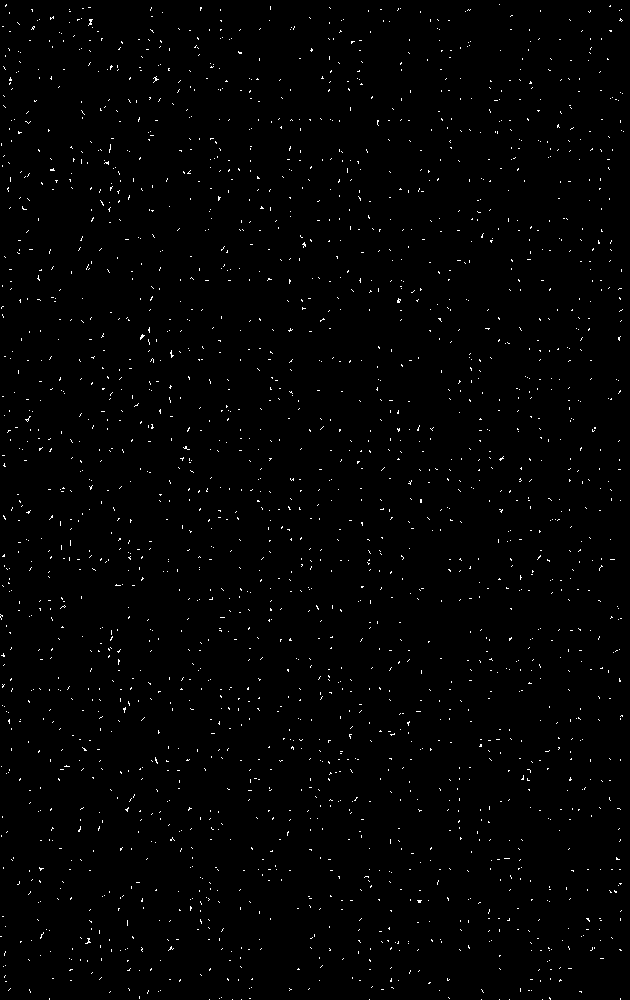

Iteration: 50100 loss: 2621782.124 s/iter: 4.524e-02
Iteration: 50200 loss: 2632667.720 s/iter: 2.364e-02
Iteration: 50300 loss: 2622464.597 s/iter: 2.239e-02
Iteration: 50400 loss: 2634087.801 s/iter: 2.237e-02
Iteration: 50500 loss: 2635818.720 s/iter: 2.279e-02
Iteration: 50600 loss: 2635427.415 s/iter: 2.321e-02
Iteration: 50700 loss: 2617028.058 s/iter: 2.328e-02
Iteration: 50800 loss: 2637417.614 s/iter: 2.152e-02
Iteration: 50900 loss: 2636908.591 s/iter: 2.191e-02
Iteration: 51000 loss: 2627369.165 s/iter: 2.199e-02
Iteration: 51100 loss: 2613928.616 s/iter: 2.276e-02
Iteration: 51200 loss: 2651578.784 s/iter: 2.255e-02
Iteration: 51300 loss: 2619557.083 s/iter: 2.334e-02
Iteration: 51400 loss: 2625191.510 s/iter: 2.274e-02
Iteration: 51500 loss: 2651617.527 s/iter: 2.233e-02
Iteration: 51600 loss: 2608487.308 s/iter: 2.276e-02
Iteration: 51700 loss: 2637743.950 s/iter: 2.262e-02
Iteration: 51800 loss: 2631430.626 s/iter: 2.279e-02
Iteration: 51900 loss: 2615812.123 s/iter: 2.2

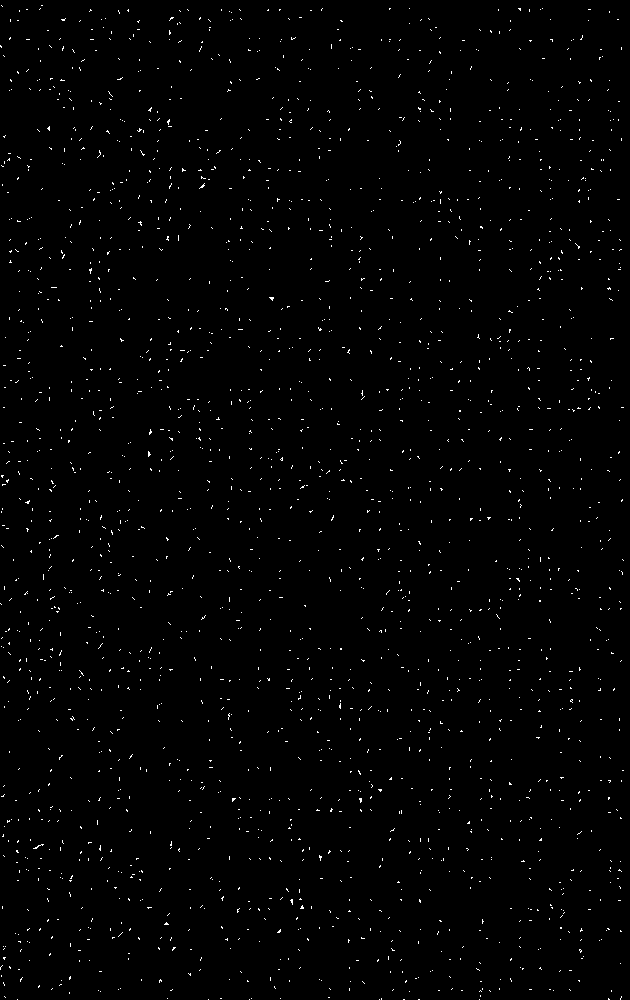

Iteration: 55100 loss: 2697819.471 s/iter: 4.434e-02
Iteration: 55200 loss: 2629841.268 s/iter: 2.260e-02
Iteration: 55300 loss: 2628452.778 s/iter: 2.274e-02
Iteration: 55400 loss: 2633457.780 s/iter: 2.165e-02
Iteration: 55500 loss: 2652987.838 s/iter: 2.143e-02
Iteration: 55600 loss: 2633466.721 s/iter: 2.231e-02
Iteration: 55700 loss: 2630638.778 s/iter: 2.315e-02
Iteration: 55800 loss: 2632787.228 s/iter: 2.267e-02
Iteration: 55900 loss: 2614503.801 s/iter: 2.221e-02
Iteration: 56000 loss: 2618520.856 s/iter: 2.268e-02
Iteration: 56100 loss: 2629156.113 s/iter: 2.293e-02
Iteration: 56200 loss: 2640907.466 s/iter: 2.323e-02
Iteration: 56300 loss: 2625813.782 s/iter: 2.218e-02
Iteration: 56400 loss: 2621748.745 s/iter: 2.283e-02
Iteration: 56500 loss: 2644532.323 s/iter: 2.227e-02
Iteration: 56600 loss: 2637220.919 s/iter: 2.242e-02
Iteration: 56700 loss: 2652854.025 s/iter: 2.240e-02
Iteration: 56800 loss: 2648783.028 s/iter: 2.269e-02
Iteration: 56900 loss: 2623421.848 s/iter: 2.3

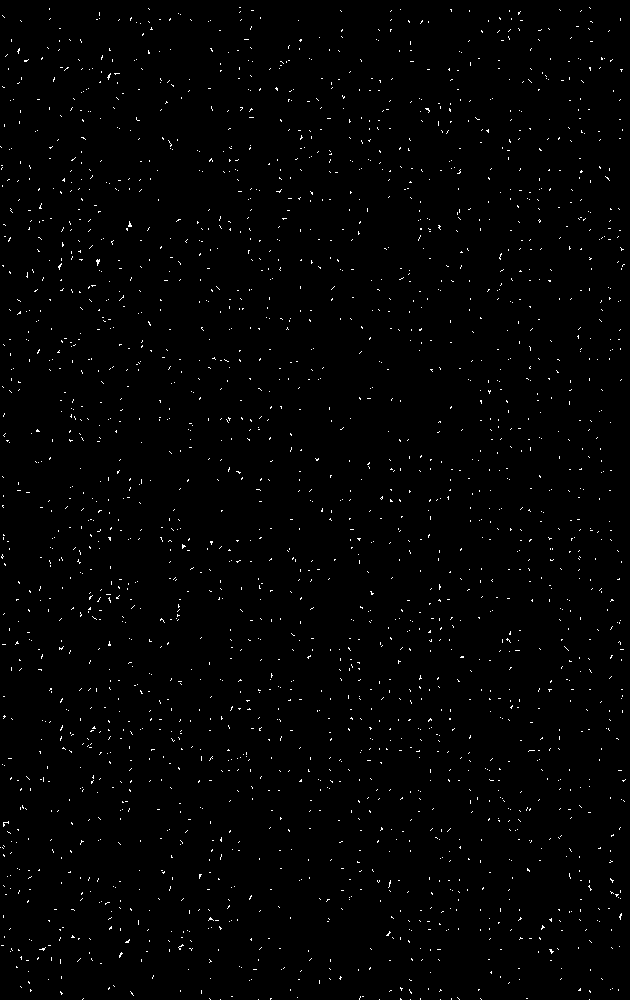

Iteration: 60100 loss: 2629239.857 s/iter: 4.457e-02
Iteration: 60200 loss: 2635330.260 s/iter: 2.294e-02
Iteration: 60300 loss: 2624393.702 s/iter: 2.249e-02
Iteration: 60400 loss: 2631053.925 s/iter: 2.276e-02
Iteration: 60500 loss: 2624117.434 s/iter: 2.337e-02
Iteration: 60600 loss: 2638564.110 s/iter: 2.269e-02
Iteration: 60700 loss: 2648922.503 s/iter: 2.263e-02
Iteration: 60800 loss: 2610505.819 s/iter: 2.222e-02
Iteration: 60900 loss: 2630784.512 s/iter: 2.249e-02
Iteration: 61000 loss: 2624617.219 s/iter: 2.225e-02
Iteration: 61100 loss: 2623565.495 s/iter: 2.240e-02
Iteration: 61200 loss: 2615691.125 s/iter: 2.291e-02
Iteration: 61300 loss: 2627058.625 s/iter: 2.287e-02
Iteration: 61400 loss: 2634330.094 s/iter: 2.274e-02
Iteration: 61500 loss: 2633249.462 s/iter: 2.255e-02
Iteration: 61600 loss: 2642730.474 s/iter: 2.273e-02
Iteration: 61700 loss: 2688110.471 s/iter: 2.274e-02
Iteration: 61800 loss: 2635334.134 s/iter: 2.223e-02
Iteration: 61900 loss: 2657049.298 s/iter: 2.2

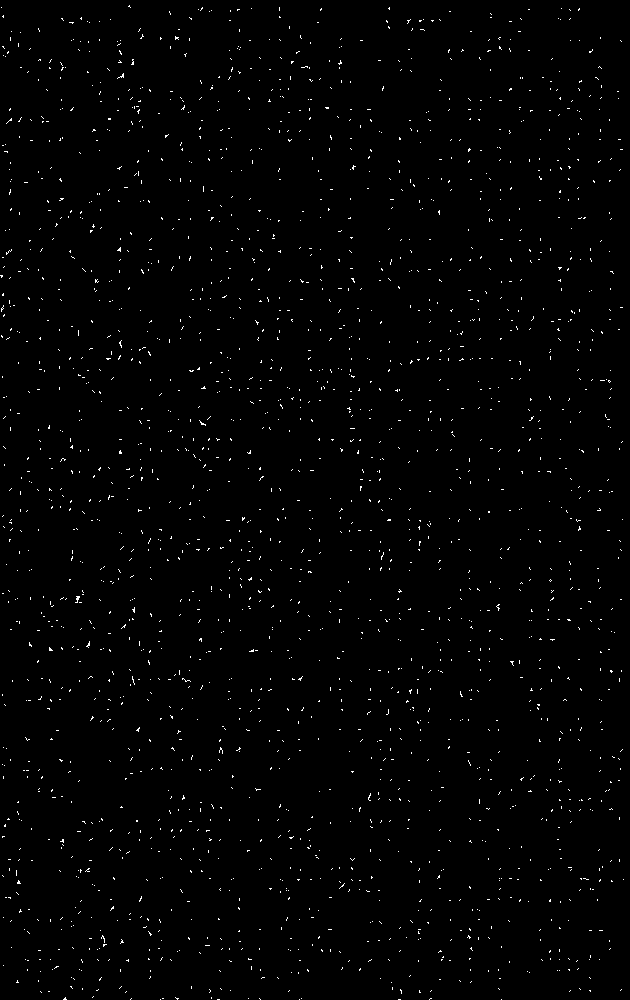

Iteration: 65100 loss: 2618857.324 s/iter: 4.416e-02
Iteration: 65200 loss: 2623969.913 s/iter: 2.275e-02
Iteration: 65300 loss: 2620280.385 s/iter: 2.240e-02
Iteration: 65400 loss: 2672895.193 s/iter: 2.256e-02
Iteration: 65500 loss: 2667231.560 s/iter: 2.280e-02
Iteration: 65600 loss: 2642408.013 s/iter: 2.286e-02
Iteration: 65700 loss: 2616755.962 s/iter: 2.273e-02
Iteration: 65800 loss: 2626785.338 s/iter: 2.318e-02
Iteration: 65900 loss: 2632439.137 s/iter: 2.166e-02
Iteration: 66000 loss: 2625818.551 s/iter: 2.264e-02
Iteration: 66100 loss: 2627038.062 s/iter: 2.327e-02
Iteration: 66200 loss: 2617017.031 s/iter: 2.332e-02
Iteration: 66300 loss: 2601975.203 s/iter: 2.280e-02
Iteration: 66400 loss: 2648739.815 s/iter: 2.092e-02
Iteration: 66500 loss: 2610218.227 s/iter: 2.275e-02
Iteration: 66600 loss: 2606966.794 s/iter: 2.288e-02
Iteration: 66700 loss: 2660809.755 s/iter: 2.214e-02
Iteration: 66800 loss: 2640164.196 s/iter: 2.254e-02
Iteration: 66900 loss: 2631526.887 s/iter: 2.2

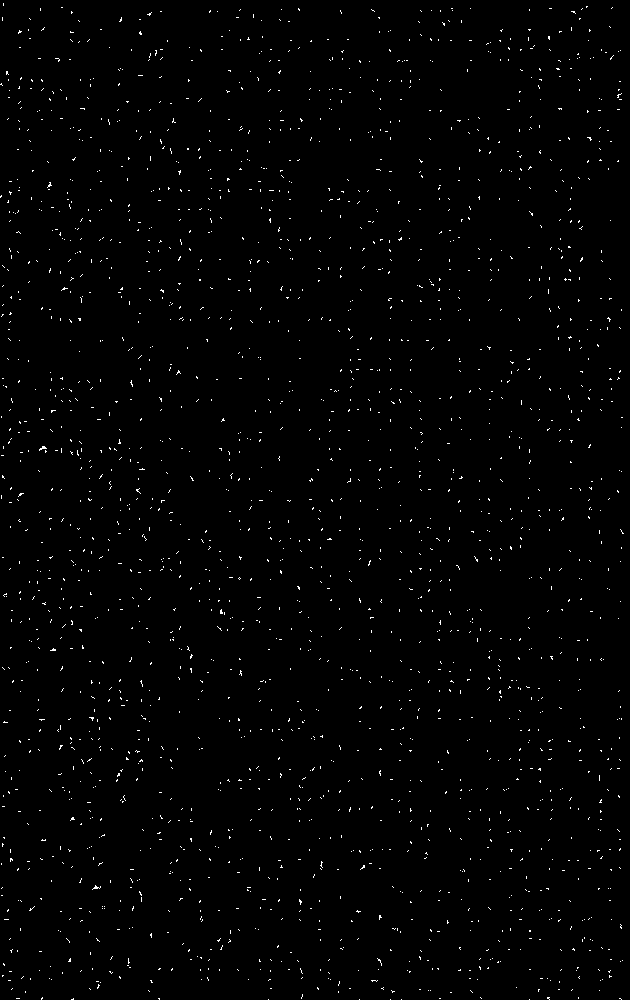

Iteration: 70100 loss: 2621092.498 s/iter: 4.451e-02
Iteration: 70200 loss: 2610081.434 s/iter: 2.248e-02
Iteration: 70300 loss: 2644830.644 s/iter: 2.177e-02
Iteration: 70400 loss: 2603704.333 s/iter: 2.278e-02
Iteration: 70500 loss: 2630207.241 s/iter: 2.248e-02
Iteration: 70600 loss: 2639187.574 s/iter: 2.250e-02
Iteration: 70700 loss: 2624747.157 s/iter: 2.167e-02
Iteration: 70800 loss: 2626322.508 s/iter: 2.189e-02
Iteration: 70900 loss: 2634792.924 s/iter: 2.251e-02
Iteration: 71000 loss: 2636053.562 s/iter: 2.342e-02
Iteration: 71100 loss: 2612101.436 s/iter: 2.296e-02
Iteration: 71200 loss: 2773286.104 s/iter: 2.201e-02
Iteration: 71300 loss: 2622834.742 s/iter: 2.423e-02
Iteration: 71400 loss: 2620190.084 s/iter: 2.561e-02
Iteration: 71500 loss: 2655176.818 s/iter: 2.503e-02
Iteration: 71600 loss: 2638874.650 s/iter: 2.574e-02
Iteration: 71700 loss: 2645644.248 s/iter: 2.259e-02
Iteration: 71800 loss: 2762281.299 s/iter: 2.325e-02
Iteration: 71900 loss: 2638477.981 s/iter: 2.3

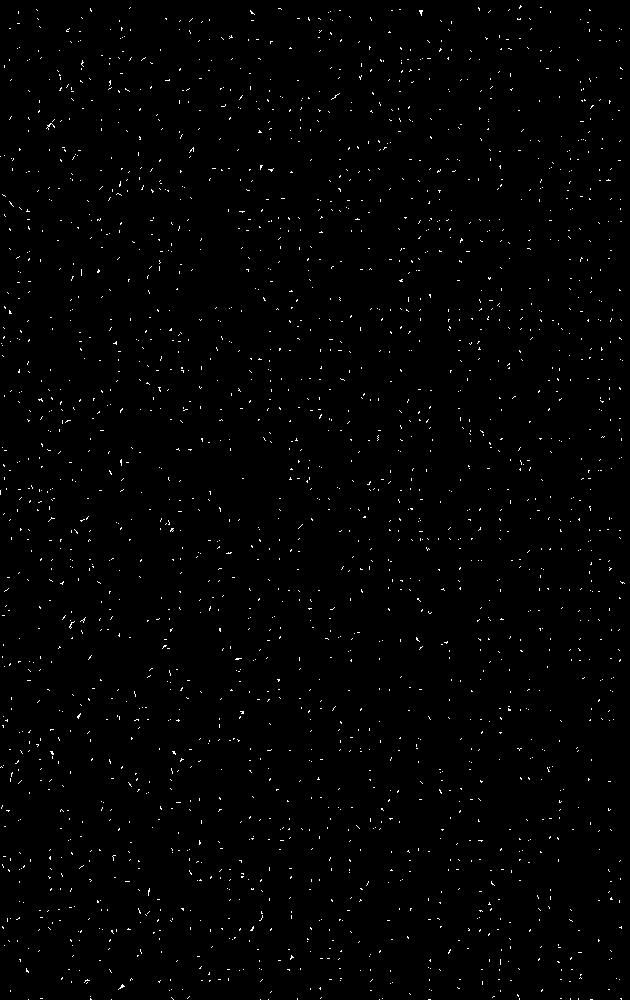

Iteration: 75100 loss: 3269618.750 s/iter: 4.316e-02
Iteration: 75200 loss: 2654070.258 s/iter: 2.203e-02
Iteration: 75300 loss: 2635950.744 s/iter: 2.297e-02
Iteration: 75400 loss: 2619874.477 s/iter: 2.295e-02
Iteration: 75500 loss: 2635875.642 s/iter: 2.261e-02
Iteration: 75600 loss: 2621098.757 s/iter: 2.235e-02
Iteration: 75700 loss: 2629315.555 s/iter: 2.187e-02
Iteration: 75800 loss: 2626583.278 s/iter: 2.261e-02
Iteration: 75900 loss: 2613432.705 s/iter: 2.271e-02
Iteration: 76000 loss: 2623555.064 s/iter: 2.230e-02
Iteration: 76100 loss: 2640709.579 s/iter: 2.192e-02
Iteration: 76200 loss: 2645944.655 s/iter: 2.297e-02
Iteration: 76300 loss: 2626926.899 s/iter: 2.291e-02
Iteration: 76400 loss: 2666874.230 s/iter: 2.254e-02
Iteration: 76500 loss: 2615075.707 s/iter: 2.307e-02
Iteration: 76600 loss: 2624245.286 s/iter: 2.223e-02
Iteration: 76700 loss: 2647342.980 s/iter: 2.266e-02
Iteration: 76800 loss: 2633992.732 s/iter: 2.266e-02
Iteration: 76900 loss: 2611657.083 s/iter: 2.2

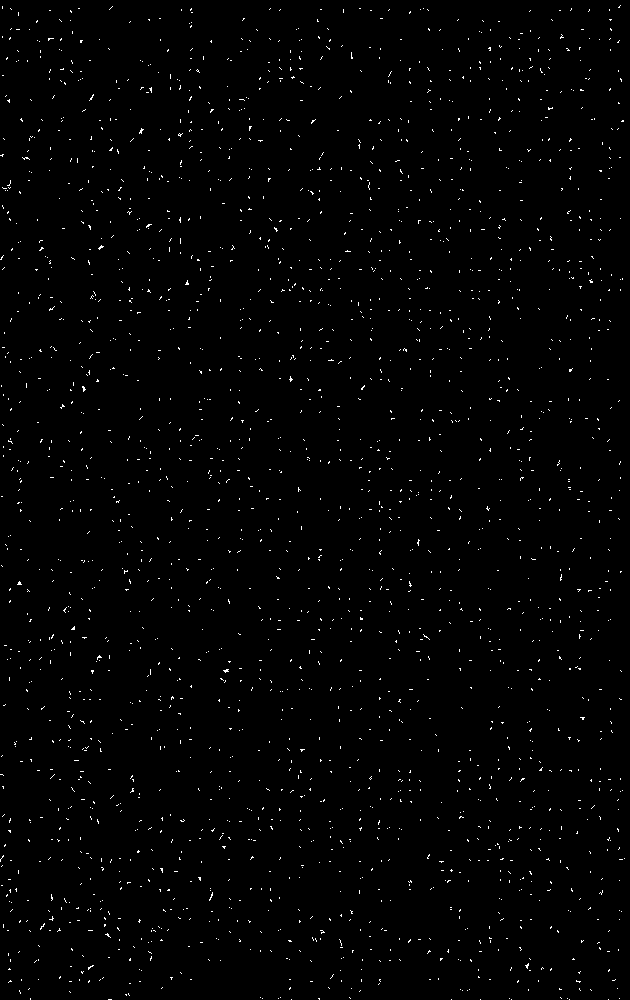

Iteration: 80100 loss: 2614314.556 s/iter: 4.515e-02
Iteration: 80200 loss: 10830142.498 s/iter: 2.308e-02
Iteration: 80300 loss: 2622905.672 s/iter: 2.245e-02
Iteration: 80400 loss: 2623290.420 s/iter: 2.296e-02
Iteration: 80500 loss: 2619720.399 s/iter: 2.283e-02
Iteration: 80600 loss: 2609497.905 s/iter: 2.271e-02
Iteration: 80700 loss: 2610244.751 s/iter: 2.339e-02
Iteration: 80800 loss: 2630382.478 s/iter: 2.273e-02
Iteration: 80900 loss: 2632492.781 s/iter: 2.306e-02
Iteration: 81000 loss: 2612807.751 s/iter: 2.219e-02
Iteration: 81100 loss: 2634201.646 s/iter: 2.197e-02
Iteration: 81200 loss: 2618924.975 s/iter: 2.117e-02
Iteration: 81300 loss: 2636348.307 s/iter: 2.125e-02
Iteration: 81400 loss: 2633245.885 s/iter: 2.226e-02
Iteration: 81500 loss: 2613290.846 s/iter: 2.290e-02
Iteration: 81600 loss: 2628918.290 s/iter: 2.261e-02
Iteration: 81700 loss: 2632562.518 s/iter: 2.294e-02
Iteration: 81800 loss: 2635113.895 s/iter: 2.219e-02
Iteration: 81900 loss: 2624973.357 s/iter: 2.

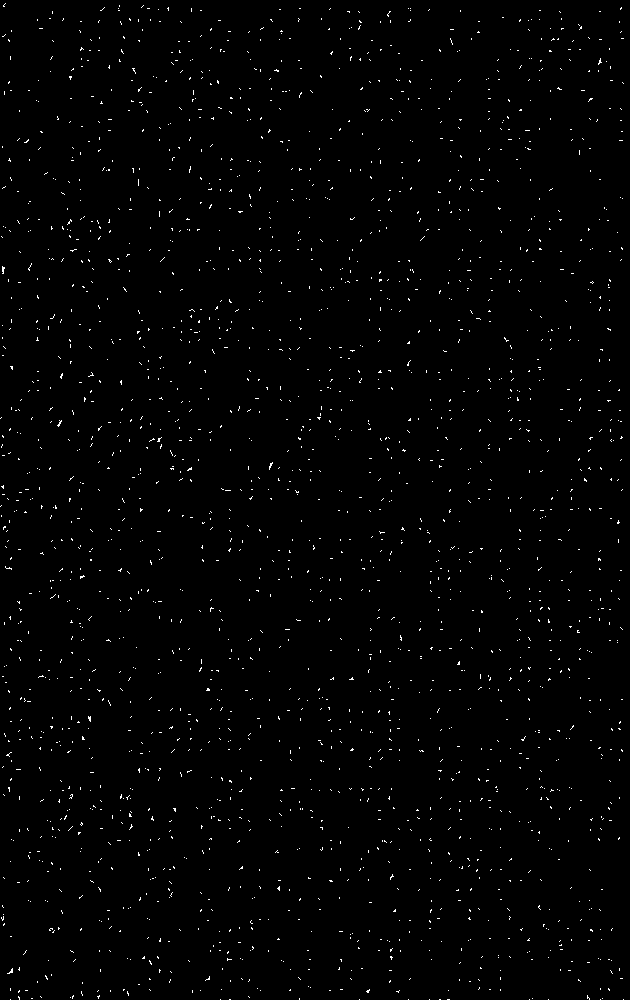

Iteration: 85100 loss: 2626419.365 s/iter: 4.772e-02
Iteration: 85200 loss: 2614732.981 s/iter: 2.169e-02
Iteration: 85300 loss: 2630878.091 s/iter: 2.277e-02
Iteration: 85400 loss: 2652881.145 s/iter: 2.291e-02
Iteration: 85500 loss: 2627263.367 s/iter: 2.290e-02
Iteration: 85600 loss: 2620141.506 s/iter: 2.133e-02
Iteration: 85700 loss: 2631080.151 s/iter: 2.233e-02
Iteration: 85800 loss: 2636387.348 s/iter: 2.277e-02
Iteration: 85900 loss: 2638671.100 s/iter: 2.266e-02
Iteration: 86000 loss: 2636436.224 s/iter: 2.262e-02
Iteration: 86100 loss: 2633199.394 s/iter: 2.204e-02
Iteration: 86200 loss: 2644959.986 s/iter: 2.149e-02
Iteration: 86300 loss: 2637653.649 s/iter: 2.259e-02
Iteration: 86400 loss: 2610617.876 s/iter: 2.259e-02
Iteration: 86500 loss: 2625238.895 s/iter: 2.263e-02
Iteration: 86600 loss: 2627407.908 s/iter: 2.198e-02
Iteration: 86700 loss: 2625648.975 s/iter: 2.273e-02
Iteration: 86800 loss: 2627697.587 s/iter: 2.192e-02
Iteration: 86900 loss: 2633221.745 s/iter: 2.2

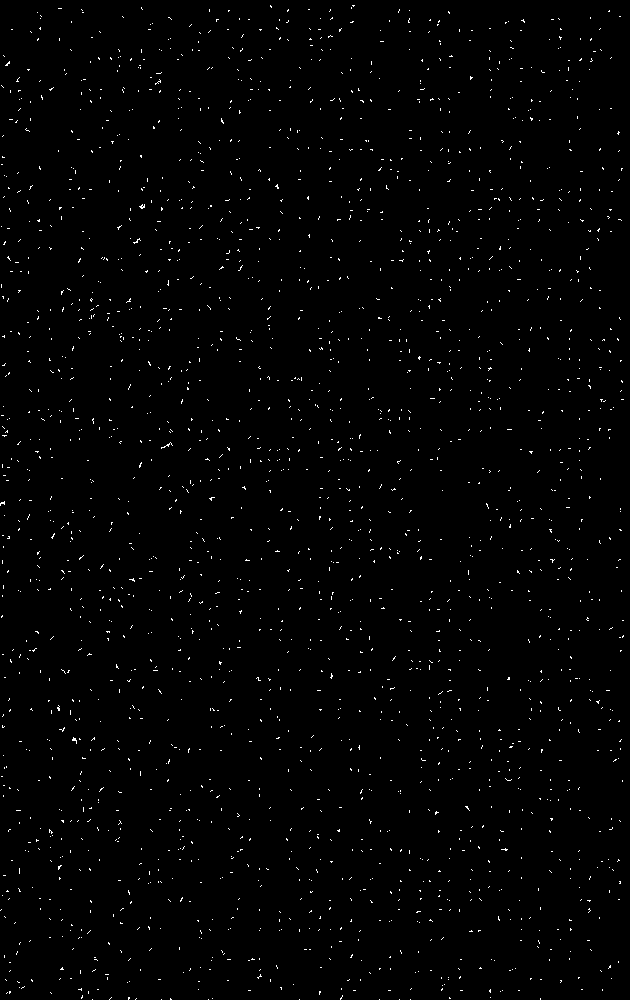

Iteration: 90100 loss: 2645863.891 s/iter: 4.465e-02
Iteration: 90200 loss: 2637315.392 s/iter: 2.216e-02
Iteration: 90300 loss: 2610333.264 s/iter: 2.198e-02
Iteration: 90400 loss: 2613086.700 s/iter: 2.311e-02
Iteration: 90500 loss: 2625880.241 s/iter: 2.308e-02
Iteration: 90600 loss: 2655209.303 s/iter: 2.244e-02
Iteration: 90700 loss: 2797549.367 s/iter: 2.245e-02
Iteration: 90800 loss: 2620646.656 s/iter: 2.208e-02
Iteration: 90900 loss: 2645140.290 s/iter: 2.240e-02
Iteration: 91000 loss: 2615474.164 s/iter: 2.226e-02
Iteration: 91100 loss: 2626222.372 s/iter: 2.244e-02
Iteration: 91200 loss: 2624067.366 s/iter: 2.316e-02
Iteration: 91300 loss: 2641216.218 s/iter: 2.269e-02
Iteration: 91400 loss: 2624114.156 s/iter: 2.304e-02
Iteration: 91500 loss: 2915313.840 s/iter: 2.269e-02
Iteration: 91600 loss: 2648331.225 s/iter: 2.269e-02
Iteration: 91700 loss: 2619398.832 s/iter: 2.233e-02
Iteration: 91800 loss: 2601862.252 s/iter: 2.260e-02
Iteration: 91900 loss: 2639331.520 s/iter: 2.3

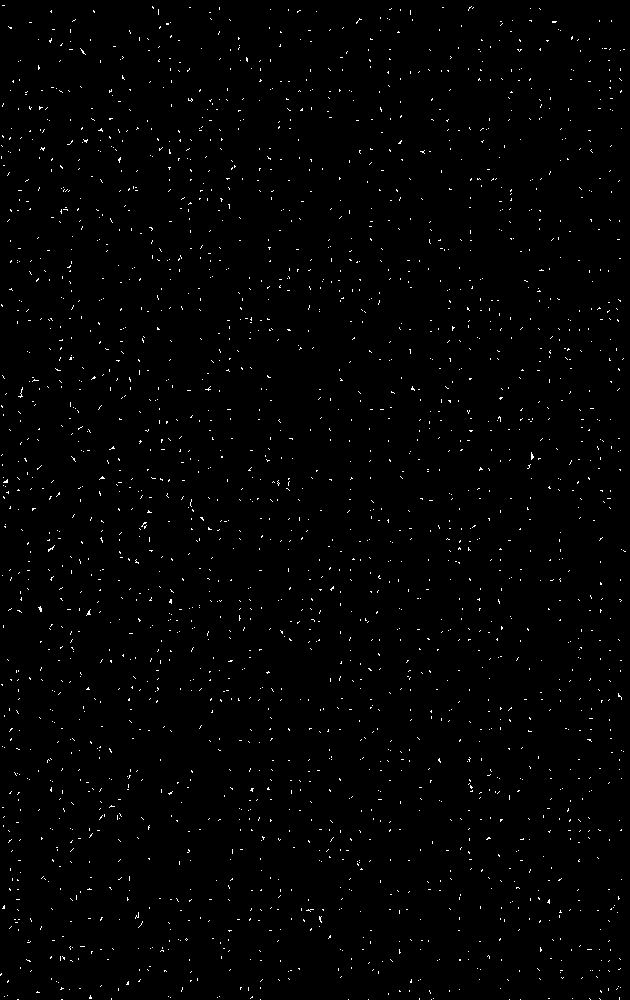

Iteration: 95100 loss: 2802645.266 s/iter: 4.551e-02
Iteration: 95200 loss: 2671141.326 s/iter: 2.266e-02
Iteration: 95300 loss: 2612261.772 s/iter: 2.189e-02
Iteration: 95400 loss: 2633658.051 s/iter: 2.234e-02
Iteration: 95500 loss: 2636632.919 s/iter: 2.279e-02
Iteration: 95600 loss: 2604398.727 s/iter: 2.301e-02
Iteration: 95700 loss: 2639864.385 s/iter: 2.247e-02
Iteration: 95800 loss: 2630108.893 s/iter: 2.241e-02
Iteration: 95900 loss: 2646352.053 s/iter: 2.108e-02
Iteration: 96000 loss: 2632353.008 s/iter: 2.297e-02
Iteration: 96100 loss: 2633932.531 s/iter: 2.296e-02
Iteration: 96200 loss: 2623943.985 s/iter: 2.282e-02
Iteration: 96300 loss: 2615847.290 s/iter: 2.291e-02
Iteration: 96400 loss: 2617730.796 s/iter: 2.239e-02
Iteration: 96500 loss: 2631006.539 s/iter: 2.239e-02
Iteration: 96600 loss: 2627655.268 s/iter: 2.215e-02
Iteration: 96700 loss: 2630885.839 s/iter: 2.296e-02
Iteration: 96800 loss: 2618468.404 s/iter: 2.218e-02
Iteration: 96900 loss: 2608223.855 s/iter: 2.2

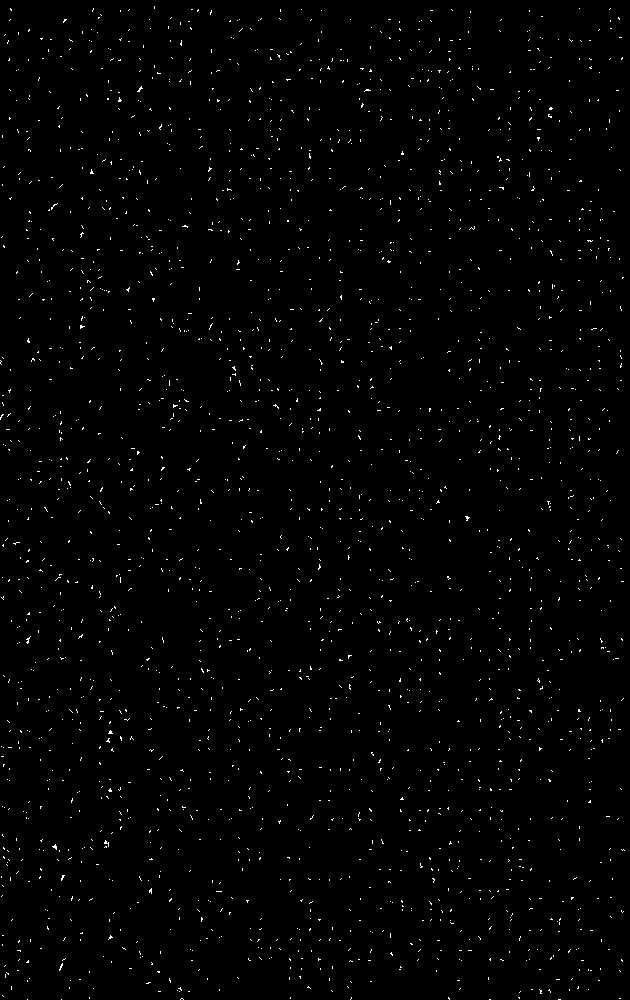

In [11]:
# Run training
with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)

  #print('Saving TensorBoard summaries and images to: %s' % FLAGS.logdir)
  #train_writer = tf.summary.FileWriter(FLAGS.logdir, sess.graph)

  t0 = time.time()
  for i in range(FLAGS.iterations+1):
    #print(loss.eval())

    #sess.run([tf.add_check_numerics_ops(), train_op])
    sess.run(train_op)

    # Print progress and save samples every so often
    if i % FLAGS.print_every == 0:
      np_loss = sess.run(loss)
      #train_writer.add_summary(summary_str, i)
      print('Iteration: {0:d} loss: {1:.3f} s/iter: {2:.3e}'.format(
          i,
          np_loss / FLAGS.batch_size  * 1e9,
          (time.time() - t0) / FLAGS.print_every))
      t0 = time.time()

      # Save samples
#       np_posterior_samples, np_prior_samples = sess.run(
#           [posterior_predictive_samples, prior_predictive_samples])
      # for k in range(FLAGS.n_samples):
    if i % (FLAGS.print_every*50) == 0:
      display(drawOutlines(posterior_predictive_samples.eval(), cellsize=10, glyphCount=glyphNum))
      #display(drawOutlines(np_prior_samples, cellsize=30, glyphCount=glyphNum))
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_posterior_predictive_%d_data.jpg' % (i, k))
      #imsave(f_name, np_x[k, :, :, 0])
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_posterior_predictive_%d_sample.jpg' % (i, k))
      #imsave(f_name, np_posterior_samples[k, :, :, 0])
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_prior_predictive_%d.jpg' % (i, k))
      #imsave(f_name, np_prior_samples[k, :, :, 0])


In [ ]:
      # Plot the posterior predictive space
      #     if FLAGS.latent_dim == 2:
      #       np_q_mu = sess.run(q_mu, {x: np_x_fixed})
      #       cmap = mpl.colors.ListedColormap(sns.color_palette("husl"))
      #       f, ax = plt.subplots(1, figsize=(6 * 1.1618, 6))
      #       im = ax.scatter(np_q_mu[:, 0], np_q_mu[:, 1], c=np.argmax(np_y, 1), cmap=cmap,
      #                       alpha=0.7)
      #       ax.set_xlabel('First dimension of sampled latent variable $z_1$')
      #       ax.set_ylabel('Second dimension of sampled latent variable mean $z_2$')
      #       ax.set_xlim([-10., 10.])
      #       ax.set_ylim([-10., 10.])
      #       f.colorbar(im, ax=ax, label='Digit class')
      #       plt.tight_layout()
      #       plt.savefig(os.path.join(FLAGS.logdir,
      #                                'posterior_predictive_map_frame_%d.png' % i))
      #       plt.close()

      #       nx = ny = 20
      #       x_values = np.linspace(-3, 3, nx)
      #       y_values = np.linspace(-3, 3, ny)
      #       canvas = np.empty((28 * ny, 28 * nx))
      #       for ii, yi in enumerate(x_values):
      #         for j, xi in enumerate(y_values):
      #           np_z = np.array([[xi, yi]])
      #           x_mean = sess.run(prior_predictive_inp_sample, {z_input: np_z})
      #           canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
      #                  28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
      #       imsave(os.path.join(FLAGS.logdir,
      #                           'prior_predictive_map_frame_%d.png' % i), canvas)
      # plt.figure(figsize=(8, 10))
      # Xi, Yi = np.meshgrid(x_values, y_values)
      # plt.imshow(canvas, origin="upper")
      # plt.tight_layout()
      # plt.savefig()
